In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## 資料前處理

## <font color=#ffa>資料集
蘋果日報：娛樂時尚, 3C車市, 國際, 生活, 社會, 政治, 體育  
檢索時段：2024年4月  
資料筆數：4492筆
</font>

In [4]:
udn = pd.read_csv("CSV/appleNews04.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,CITIZEN抗磁飛行錶端酷帥鋼鐵灰、曜石黑 韋禮安搶先戴上手,2024-04-01 18:41:00,娛樂時尚,https://tw.nextapple.com/entertainment/2024040...,【記者劉旻君／台北報導】若是經常出遊的outdoor派，也許對日本鐘錶品牌CITIZEN的P...,appleDaily
1,2,劉香慈高齡懷第3胎 不敢驗「唐氏症」！曝心中有堅定答案,2024-04-01 07:52:00,娛樂時尚,https://tw.nextapple.com/entertainment/2024040...,【王怡人／綜合報導】40歲「最美士官長」劉香慈和永信藥品總經理鍾威凱育有2子，兩人婚姻剛跨越...,appleDaily
2,3,南拳媽媽張傑與「他」穩交6年 最新戀情成果曝光,2024-04-01 18:10:00,娛樂時尚,https://tw.nextapple.com/entertainment/2024040...,【記者林秭渝／台北報導】曾奪下亞洲、東亞、世界運動會的健美比賽拿過銀牌、金牌和銅牌的許家豪，...,appleDaily


In [4]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,記者劉旻君台北報導若是經常出遊的派也許對日本鐘錶品牌的系列不陌生近日該系列又有新作登場端出首...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 18:41:00
1,王怡人綜合報導歲最美士官長劉香慈和永信藥品總經理鍾威凱育有子兩人婚姻剛跨越七年之癢她開心懷上...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 07:52:00
2,記者林秭渝台北報導曾奪下亞洲東亞世界運動會的健美比賽拿過銀牌金牌和銅牌的許家豪與從歌手轉戰健...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 18:10:00


In [5]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from c:\新電腦\課業\1122\社媒\w10\期末\dict\dict.txt.big ...
2024-05-05 23:47:36,215 : DEBUG : Building prefix dict from c:\新電腦\課業\1122\社媒\w10\期末\dict\dict.txt.big ...
Loading model from cache C:\Users\win90\AppData\Local\Temp\jieba.u7ceb51d5e090774a1d7e965ba195b2ac.cache
2024-05-05 23:47:36,217 : DEBUG : Loading model from cache C:\Users\win90\AppData\Local\Temp\jieba.u7ceb51d5e090774a1d7e965ba195b2ac.cache
Loading model cost 0.873 seconds.
2024-05-05 23:47:37,090 : DEBUG : Loading model cost 0.873 seconds.
Prefix dict has been built successfully.
2024-05-05 23:47:37,091 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,記者劉旻君台北報導若是經常出遊的派也許對日本鐘錶品牌的系列不陌生近日該系列又有新作登場端出首...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 18:41:00,"[劉旻君, 台北, 出遊, 也許, 日本, 鐘錶, 品牌, 系列, 陌生, 近日, 系列, ..."
1,王怡人綜合報導歲最美士官長劉香慈和永信藥品總經理鍾威凱育有子兩人婚姻剛跨越七年之癢她開心懷上...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 07:52:00,"[王怡, 最美, 士官長, 劉香, 慈和, 永信, 藥品, 總經理, 威凱育, 有子, 兩人..."
2,記者林秭渝台北報導曾奪下亞洲東亞世界運動會的健美比賽拿過銀牌金牌和銅牌的許家豪與從歌手轉戰健...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 18:10:00,"[秭渝, 台北, 奪下, 亞洲, 東亞, 世界, 運動會, 健美, 比賽, 拿過, 銀牌, ..."
3,吳惠菁綜合報導愚人節搞笑日本電視台生活資訊節目突然插播北韓領導人金正恩閱兵的影片引起網友恐慌...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 11:58:00,"[吳惠菁, 愚人節, 搞笑, 日本, 電視, 生活, 資訊, 節目, 突然, 插播, 北韓,..."
4,記者陳薇安綜合報導打造出經典劇如果歲還是處男似乎就能成為魔法師的日本東京電視台又有新作推出改...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 21:46:00,"[打造出, 經典, 處男, 似乎, 成為, 魔法師, 日本, 東京, 電視, 新作, 推出,..."


# 1. Lexicon-based 人工給定主題的主題模型

#### 查看有幾種版別

In [6]:
udn['artCatagory'].unique()

array(['娛樂時尚', '3C車市', '國際', '生活', '社會', '政治', '體育'], dtype=object)

### 查看每個版別當中前100的字詞

In [7]:
## 定義主題
joy_cnt = udn.loc[udn['artCatagory'] == '娛樂時尚',:]['words'].explode().value_counts().head(100)
joy_cnt.index

Index(['台北', '粉絲', '黃子佼', '網友', '台灣', '覺得', '真的', '希望', '演出', '一起', '節目', '品牌',
       '看到', '透露', '媽媽', '電影', '演唱會', '知道', '合作', '現在', '最後', '系列', '拍攝', '喜歡',
       '工作', '韓國', '導演', '當時', '時間', '藝人', '這次', '現場', '已經', '分享', '音樂', '一直',
       '活動', '角色', '觀眾', '影片', '開心', '特別', '許多', '兩人', '日本', '朋友', '對方', '女兒',
       '公司', '推出', '相當', '飾演', '去年', '今日', '地震', '作品', '日前', '透過', '設計', '演員',
       '發文', '發現', '成為', '今年', '機會', '生活', '全新', '留言', '表演', '歌迷', '應該', '成員',
       '少女', '造型', '未成年', '事情', '事件', '老婆', '搭配', '需要', '製作', '演藝圈', '發生',
       '目前', '過去', '感謝', '老公', '回應', '出席', '感覺', '坦言', '中國', '歌手', '舉辦', '支持',
       '努力', '準備', '之後', '直接', '之前'],
      dtype='object', name='words')

In [8]:
car_cnt = udn.loc[udn['artCatagory'] == '3C車市',:]['words'].explode().value_counts().head(200)
pprint(" ".join(car_cnt.index))

('提供 系統 車主 全新 台北 台灣 體驗 活動 科技 林浩 搭配 車輛 設計 品牌 汽車 透過 智慧 車型 服務 輔助 萬元 配備 搭載 車款 性能 '
 '消費者 升級 推出 原廠 市場 擁有 車系 動力 優惠 模式 包含 帶來 全球 車身 專屬 銷售 功能 提升 持續 產品 導入 空間 最大 方案 打造 '
 '獲得 輪胎 安全 風格 花蓮 未來 選擇 煞車 行車 售價 充電 系列 部分 正式 舉辦 即日起 之外 座椅 世代 結合 生活 年度 購車 機車 特別 '
 '電動車 同步 頭燈 旗下 玩具 採用 達到 展現 運動 這次 使用 最高 福斯 商用車 總代理 最佳 針對 需求 集團 車迷 免費 進行 今年 駕駛 '
 '實力 上市 永續 滿足 行駛 引擎 大樂 數位 操控 露營 經典 國內 回饋 感受 超過 商旅 限量 成為 新車 調整 電動 零件 表現 輸出 維修 '
 '電車 標配 福特 環景 保固 更是 森那美 起亞 輕鬆 試駕 面對 樂趣 駕馭 騎乘 智慧型 手機 舒適 純電 現場 無線 地力 平台 攜手 豪華 共同 '
 '影音 之後 成長 發展 全面 座艙 視覺 顯示 快速 跑車 外型 旗艦 以來 獨特 同級 方式 日本 移動 享有 用車 整合 最新 主動 乘客 扭力 '
 '馬力 展示 技術 外觀 自動 大型 受災 多功能 主廚 鑰匙 購買 家庭 進階 傳統 呈現 氛圍 義大利 雪鐵龍 限時 報名 豐富 電動機 資訊 限量版 '
 '味全 懸吊')


In [9]:
global_cnt = udn.loc[udn['artCatagory'] == '國際',:]['words'].explode().value_counts().head(200)
pprint(" ".join(global_cnt.index))

('中國 美國 台灣 日本 外電 以色列 發生 一名 指出 伊朗 地震 已經 中央社 攻擊 發現 警方 國家 拜登 公司 目前 總統 男子 包括 進行 媒體 '
 '造成 飛彈 調查 台幣 安全 影片 當時 問題 去年 網友 影響 研究 機場 時間 國際 民眾 要求 事件 社群 英國 提供 許多 相關 這是 無人機 '
 '烏克蘭 超過 澳洲 今年 全球 無法 支持 周恩華 出現 導致 活動 劉育良 正在 工作 宣布 當地 透過 情況 員工 行動 日圓 有人 女性 接受 '
 '地區 南韓 使用 政府 合作 需要 俄羅斯 過去 是否 中心 持續 平台 萬元 日前 希望 現在 學生 行為 大學 增加 顯示 成為 最大 花蓮 人員 '
 '余平 官員 之後 受到 死亡 發布 億美元 飛機 舉行 進入 系統 現場 新聞 引發 習近平 李威翰 北京 威脅 這項 重要 這次 附近 醫院 網站 '
 '準備 來自 確認 手機 照片 經濟 針對 當局 軍事 部分 海嘯 內容 世界 紀錄 駕駛 聲明 小時 企業 看到 能力 告訴 強調 以來 規模 遭到 '
 '指控 穩定 決定 網路 關係 逮捕 提出 發動 川普 公布 受傷 面臨 知道 菲律賓 獲得 所有 東京 發展 新加坡 一直 生活 女子 男性 最後 真的 '
 '協助 法院 一起 風險 委員會 嚴重 共同 方式 特斯拉 人士 航空 年月日 應該 地方 這名 服務 組織 法案 北韓 至少 回應 衝突 香港 車輛 '
 '對方 旅客 保護')


In [10]:
life_cnt = udn.loc[udn['artCatagory'] == '生活',:]['words'].explode().value_counts().head(200)
pprint(" ".join(life_cnt.index))

('地區 地震 天氣 台北 短暫 發生 台灣 陣雨 指出 民眾 活動 花蓮 影響 局部 各地 出現 降雨 多雲 網友 目前 今日 機率 工作 雷雨 提供 '
 '進行 氣溫 鋒面 花蓮縣 時間 氣象 台北市 相關 造成 規模 以上 北部 環境 中心 發現 山區 部分 萬安 公司 新聞 持續 舒適 安全 桃園 '
 '衛生局 政府 醫院 時分 使用 醫師 學生 溫度 服務 萬元 問題 透過 高溫 今年 高雄市 最大 資料 通報 至度 針對 健康 穩定 提醒 包括 協助 '
 '說明 機會 需要 本週 學校 白天 市府 推出 悶熱 影片 希望 中央 日本 特別 超過 注意 市長 未來 路段 教育 狀況 期間 現場 整體 東部 '
 '人員 熱門 系統 方面 真的 預計 是否 完成 文化 發展 強震 前往 中部 嚴重 之間 許多 症狀 治療 日前 高雄 一名 公里 患者 調查 食物中毒 '
 '國際 臺北市 建議 合作 留意 午後 已經 台南 資訊 業者 舉辦 上午 增加 東半 分享 朋友 範圍 改善 新北 來源 晚間 兒童 臺灣 處理 捐款 '
 '導致 食品 南部 醫療 優惠 左右 顯示 方式 情況 就醫 呼籲 檢驗 為主 晴時多雲 事件 林則 消費者 計畫 下午 地方 無法 情形 生活 新北市 '
 '寶林 臺中市 何心嵐 餐廳 一起 即時 變化 食材 餘震 對此 以下 一定 尤其 最高 專業 強調 稽查 中南部 維持 分別 後續 孩子 團隊 受到 '
 '之後 位於 半部')


In [11]:
social_cnt = udn.loc[udn['artCatagory'] == '社會',:]['words'].explode().value_counts().head(200)
pprint(" ".join(social_cnt.index))

('警方 發現 發生 新聞 熱門 男子 萬元 指出 現場 花蓮 目前 民眾 分局 台北 人員 前往 時分 地震 進行 造成 調查 駕駛 協助 相關 桃園 '
 '詐騙 安全 影片 一名 立即 搜救 法官 昨天 持續 媽祖 大甲 新北市 女子 上午 強震 消防局 機車 偵辦 通報 當時 疑似 車輛 受困 釐清 新北 '
 '嚴重 黃子佼 學生 透過 了解 後續 日前 台灣 到場 工作 導致 警員 接獲 報案 檢察官 送醫 提供 要求 受傷 原因 醫院 被害人 大樓 午時 '
 '執行 今日 步道 台中市 已經 處理 派出所 去年 毒品 員警 影像 網友 晚間 有人 無法 案件 希望 集團 時間 高雄 家屬 落石 未成年 警察 '
 '呼籲 狀況 中心 全案 規定 網站 起訴 下午 傳出 統神 砂卡 確認 針對 附近 公司 進入 死亡 活動 使用 老師 地檢署 影響 道路 公里 救援 '
 '搜索 期間 獲報 時許 年月日 違反 凱凱 鮮明 律師 通知 法院 緊急 手機 部分 移送 今年 對方 包括 災情 檢方 凌晨 方式 畫面 條例 網路 '
 '看到 所幸 車道 曾佳俊 遺體 業者 訊息 一起 第一 發文 完成 搶救 小時 騎士 依法 利用 兒子 單位 查獲 車禍 逮捕 行經 少女 行為 找到 '
 '花蓮縣 到案 張沛森 事件 不斷 事故 傷害 環境 真的 進一步 判刑 犯罪 政府 作業 學校 隨即 身分 注意 以下 市府 江孟謙 臉書 是否 曝光 '
 '維護 分別 初步')


In [12]:
policy_cnt = udn.loc[udn['artCatagory'] == '政治',:]['words'].explode().value_counts().head(200)
pprint(" ".join(policy_cnt.index))

('民進黨 國民黨 台灣 立委 總統 台北 花蓮 立法院 賴清德 政府 中國 黨團 馬英九 民眾 國家 未來 兩岸 希望 行政院 強調 主委 社會 主席 '
 '政治 指出 地震 卓榮泰 針對 過去 發生 應該 現在 相關 秘書長 內閣 國會 工作 地方 袁詩羽 問題 協助 政策 擔任 人事 支持 目前 已經 '
 '柯文 媒體 市長 公布 進行 對此 接任 投票 院長 部長 能夠 持續 時間 發言人 英文 是否 重要 知道 昨天 需要 討論 民主 要求 合作 團隊 '
 '蘇柏銓 日前 這是 質疑 傳出 提出 黃國 議員 包括 交流 發展 表決 陳建仁 面對 推動 一定 和平 提到 外界 吳崢 說明 公司 國際 宣布 詐騙 '
 '造成 特別 批評 一起 改革 委員會 回應 提供 吳思瑤 兒少 前往 安全 臉書 影像 努力 事件 共識 所有 行政院長 透過 最後 韓國 受訪 影響 '
 '事情 當時 重建 預算 繼續 選舉 代表 清楚 基金會 調查 董事長 國人 看到 接受 美國 呼籲 無法 萬元 出任 人員 部分 共同 第一 這次 '
 '未成年 表達 大陸 救災 新聞 中央 綠營 行為 黃子佼 感謝 去年 許多 處理 青年 完全 災情 真的 強震 產業 關係 名單 習近平 參與 相信 '
 '總統府 了解 盧縣 洗錢 規模 柯建銘 立法 影片 人物 記者會 發文 衛福部 台南 召開 法案 國安 人士 近日 中心 朱立倫 市府 期待 陸委會 '
 '我國 後續 嚴重 規定 歷史 機會 新北 尊重')


In [13]:
sport_cnt = udn.loc[udn['artCatagory'] == '體育',:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['聯盟', '大谷', '球員', '台灣', '比賽', '推薦', '奧運', '翔平', '球迷', '之後', '廖柏璋', '投手',
       '本季', '球隊', '生涯', '水原', '拿下', '道奇', '美國', '今年', '日本', '台北', '教練', '選手',
       '勇士', '球場', '紀錄', '棒球', '全壘打', '目前', '表現', '萬美元', '進行', '最後', '季後賽',
       '中職', '主場', '球團', '去年', '以比', '時間', '鄧愷威', '巴黎', '巨蛋', '球星', '啦啦隊',
       '希望', '網友', '籃板', '已經', '助攻', '冠軍', '職棒', '拿到', '投球', '總教練', '國王', '失分',
       '台鋼', '中信', '發生', '雄鷹', '三振', '戰神', '中央社', '巨人', '出賽', '運動', '日籍', '賽事',
       '一平', '台南', '成為', '樂天', '成績', '指出', '兄弟', '第局', '擊出', '籃球', '擔任',
       '體育中心', '狀況', '媒體', '投局', '林書豪', '取得', '機會', '接受', '先發', '領先', '過去',
       '韓國', '中華', '挑戰', '包括', '昨天', '發文', '雲豹', '連續'],
      dtype='object', name='words')

### 從每個版別前100字詞中整理出代表字

從每個版別前100字詞中篩選出代表字

In [14]:
custom_topic_word = {
    "娛樂時尚": [
        '粉絲',
        '演出',
        '品牌',
        '電影',
        '演唱會',
        '拍攝',
        '導演',
        '音樂',
        '活動',
        '觀眾',
        '飾演',
        '設計',
        '演員',
        '表演',
        '歌迷',
        '成員',
        '造型',
        '演藝圈',
        '出席',
        '歌手'
    ],
    "3C車市": [
        "系統",
        "車主",
        "科技",
        "車輛",
        "汽車",
        "智慧",
        "車型",
        "輔助",
        "搭載",
        "車款",
        "性能",
        "車系",
        "動力",
        "車身",
        "功能",
        "行車",
        "煞車",
        "充電",
        "機車",
        "電動車",
        "商用車",
        "電動",
        "零件",
        "新車",
        "電車",
        "智慧型",
        "純電",
        "電動機",
        "馬力",
        "懸吊",
    ],
    "國際": [
        "中國",
        "美國",
        "以色列",
        "伊朗",
        "攻擊",
        "國家",
        "拜登",
        "總統",
        "國際",
        "英國",
        "烏克蘭",
        "澳洲",
        "全球",
        "俄羅斯",
        "南韓",
        "政府",
        "世界",
        "北京",
        "軍事",
        "菲律賓",
        "新加坡",
        "特斯拉",
        "北韓",
        "國際"
    ],
    "生活": [
        "天氣",
        "陣雨",
        "民眾",
        "活動",
        "雷雨",
        "氣溫",
        "衛生局",
        "醫院",
        "醫師",
        "溫度",
        "服務",
        "健康",
        "學校",
        "教育",
        "患者",
        "食物中毒",
        "調查",
        "業者",
        "兒童",
        "食品",
        "醫療",
        "餐廳",
        "生活",
        "食材",
        "孩子",
        "捐款",
        "餘震",
        "稽查",
        "搶救",
        "未成年",
        "警察",
        "災情",
        "查獲",
    ],
    "政治": [
        "立委",
        "總統",
        "立法院",
        "賴清德",
        "政府",
        "中國",
        "黨團",
        "馬英九",
        "兩岸",
        "行政院",
        "主委",
        "主席",
        "政治",
        "秘書長",
        "內閣",
        "國會",
        "協助",
        "政策",
        "人事",
        "市長",
        "部長",
        "發言人",
        "民主",
        "蘇柏銓",
        "黃國",
        "議員",
        "陳建仁",
        "吳崢",
        "國際",
        "委員會",
        "吳思瑤",
        "行政院長",
        "選舉",
        "董事長",
        "美國",
        "第一",
        "總統府",
        "立法",
        "衛福部",
        "國安",
        "法案",
        "朱立倫"
    ],
    "體育": [
        "聯盟",
        "大谷",
        "球員",
        "比賽",
        "翔平",
        "奧運",
        "球迷",
        "廖柏璋",
        "投手",
        "球隊",
        "本季",
        "生涯",
        "道奇",
        "教練",
        "選手",
        "球場",
        "紀錄",
        "棒球",
        "全壘打",
        "中職",
        "季後賽",
        "球團",
        "鄧愷威",
        "球星",
        "啦啦隊",
        "籃板",
        "冠軍",
        "助攻",
        "職棒",
        "投球",
        "總教練",
        "國王",
        "失分",
        "雄鷹",
        "戰神",
        "三振",
        "出賽",
        "運動",
        "賽事",
        "樂天",
        "籃球",
        "體育中心",
        "林書豪",
        "投局",
        "先發",
        "挑戰"
    ]
}

In [15]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [16]:
vocabularies

array(['三振', '世界', '中國', '中職', '主委', '主席', '人事', '以色列', '伊朗', '俄羅斯', '健康',
       '充電', '先發', '兒童', '內閣', '全壘打', '全球', '兩岸', '冠軍', '出席', '出賽', '功能',
       '助攻', '動力', '北京', '北韓', '協助', '南韓', '吳崢', '吳思瑤', '品牌', '商用車',
       '啦啦隊', '國安', '國家', '國會', '國王', '國際', '大谷', '天氣', '失分', '奧運', '委員會',
       '季後賽', '孩子', '學校', '導演', '市長', '廖柏璋', '性能', '患者', '懸吊', '成員', '戰神',
       '投局', '投手', '投球', '拍攝', '拜登', '挑戰', '捐款', '搭載', '搶救', '攻擊', '政府',
       '政治', '政策', '教練', '教育', '新加坡', '新車', '智慧', '智慧型', '服務', '未成年',
       '本季', '朱立倫', '林書豪', '查獲', '棒球', '業者', '樂天', '機車', '歌手', '歌迷', '比賽',
       '民主', '民眾', '氣溫', '汽車', '法案', '活動', '溫度', '演出', '演員', '演唱會', '演藝圈',
       '澳洲', '災情', '烏克蘭', '煞車', '特斯拉', '球員', '球團', '球場', '球星', '球迷', '球隊',
       '生活', '生涯', '發言人', '科技', '秘書長', '稽查', '立委', '立法', '立法院', '第一',
       '籃板', '籃球', '粉絲', '系統', '紀錄', '純電', '總教練', '總統', '總統府', '美國', '翔平',
       '聯盟', '職棒', '英國', '菲律賓', '董事長', '蘇柏銓', '行政院', '行政院長', '行車', '衛生局',
       '衛福部', '表演', '觀眾', '設計', '調查', '警察', '

### 製作DTM

In [17]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies) #計算文本中詞彙數量（只會計算上方 vocabulary 有出現的詞彙的出現次數）
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()
udn_matrix.shape

(4492, 188)

In [18]:
udn_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## 分類結果

In [19]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

,topic_娛樂時尚,topic_3C車市,topic_國際,topic_生活,topic_政治,topic_體育
0,6,2,0,0,0,0
1,0,0,1,7,1,0
2,5,1,1,1,0,8
3,1,0,2,1,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
4487,0,0,0,0,0,8
4488,0,2,0,0,0,33
4489,0,0,0,0,0,9
4490,0,0,3,0,4,11


In [20]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_娛樂時尚,topic_3C車市,topic_國際,topic_生活,topic_政治,topic_體育
0,0.7500,0.2500,0.000000,0.000000,0.000000,0.0
1,0.0000,0.0000,0.111111,0.777778,0.111111,0.0
2,0.3125,0.0625,0.062500,0.062500,0.000000,0.5
3,0.2500,0.0000,0.500000,0.250000,0.000000,0.0
4,1.0000,0.0000,0.000000,0.000000,0.000000,0.0


### 考慮加個準確率?

# 2. LDA 主題模型

### 處理新聞

In [21]:
docs = udn['words'].to_list()
print(docs[0])

['劉旻君', '台北', '出遊', '也許', '日本', '鐘錶', '品牌', '系列', '陌生', '近日', '系列', '新作', '登場', '首款', '具備', '兩地', '時間', '抗磁', '機械', '飛行', '腕錶', '搭配', '寬大', '指針', '切角', '造型', '代言人', '韋禮安', '搶先', '戴上', '擁有', '酷帥', '外觀', '腕錶', '秀出', '機能', '時尚', '專業', '飛行', '腕錶', '系列', '全新', '推出', '抗磁', '機械', '飛行', '腕錶', '選用', '深色', '面盤', '之外', '具備', '清晰', '易讀', '寬大', '指針', '設計', '搭配', '阿拉伯數字', '條形', '刻度', '飛行員', '正確', '快速', '辨別', '時間', '透過', '單面', '防眩', '藍寶石', '玻璃', '鏡面', '減少', '讀時', '所受', '反光', '影響', '夜光', '時標', '指針', '則使', '飛行員', '昏暗', '座艙', '依然', '清晰', '可視', '透過', '旋轉', '點鐘', '方向', '轉動', '錶盤', '外圈', '航空', '飛行', '用來', '計算', '飛行速度', '時間', '油耗', '資訊', '擁有', '優異', '機能', '擅長', '粗曠', '外表', '展現', '日系', '細膩', '美學', '系列', '此次', '機身', '圓潤', '外型', '化為', '小時', '設計', '靈感', '強化', '飛行', '腕錶', '兩地', '時間', '功能', '連結', '性而', '錶殼', '錶帶', '接合處', '流動', '切角', '造型', '則是將', '飛機', '航行', '時機', '橫切面', '劃過', '天空', '畫面', '融入', '設計', '側邊', '採用', '滾花', '加工', '凸顯出', '強悍', '風格', '增加', '摩擦阻力', '飛行員', '配戴', '飛行', '手套', '輕鬆', '操作', '翻至', '底蓋', '處雷刻', '飛

### 將文章數字化 

In [22]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-05 23:47:54,500 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-05 23:47:54,978 : INFO : built Dictionary<79303 unique tokens: ['上鍊', '不鏽鋼', '之外', '也許', '代言人']...> from 4492 documents (total 764406 corpus positions)
2024-05-05 23:47:54,979 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<79303 unique tokens: ['上鍊', '不鏽鋼', '之外', '也許', '代言人']...> from 4492 documents (total 764406 corpus positions)", 'datetime': '2024-05-05T23:47:54.979904', 'gensim': '4.3.2', 'python': '3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}
2024-05-05 23:47:55,035 : INFO : discarding 63113 tokens: [('上鍊', 4), ('不鏽鋼', 4), ('光譜', 3), ('切角', 1), ('刻度', 4), ('則使', 2), ('則是將', 2), ('則能', 4), ('劃過', 1), ('功能設計', 1)]...
2024-05-05 23:47:55,036 : INFO : keeping 16190 tokens which were in no less than 5 and no more than 4447 (=99.0%) documents
2024-05-05 23:47:55,067 : INFO : result

Dictionary<16190 unique tokens: ['之外', '也許', '代言人', '佩戴', '依然']...>


查看 dictionary 內的內容

In [23]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

之外: 0
也許: 1
代言人: 2
佩戴: 3
依然: 4
側邊: 5
儀器: 6
優異: 7
全新: 8
兩地: 9
共有: 10
具備: 11


In [24]:
pprint(" ".join(udn['words'].iloc[600]))

('張瑞振 台北 俗話說 機會 一次 把握住 機會 成功 本事 無法 確定 下次 是否 機會 清水 國際 塔羅 雲蔚 老師 揭露 以下 星座 積極 把握住 '
 '機會 巨蟹座 巨蟹座 家庭 重會 積極 創造 穩定 安全 生活 環境 具有 出色 洞察力 敏感 捕捉 機會 實力 著手 處理 巨蟹座 人際關係 敏銳 '
 '感知 擅於 協作 運用 社交 技巧 拓展 機會 積極爭取 把握 機會 完成 夢想 家庭 打造 美好未來 水瓶座 水瓶座 挑戰 常規 擁有 非凡 創新 '
 '思維 滿足 現狀 喜歡 嘗試 事物 追求 突破 水瓶座 擁抱 變革 樂於 冒險 能夠 敏銳地 抓住 潛在 機會 思維 獨立 擁有 豐富 人際 脈絡 擅於 '
 '創造 合作 機會 堅信 理念 能為 社會 帶來 改變 有創造力 積極爭取 機會 星座 獅子座 獅子座 天生 充滿 自信 果斷 並很有 冒險 精神 樂於 '
 '挑戰 勇於 追求 卓越 機會 上門 敏感度 事業 生活 追求 領導 地位 擁有 強烈 企圖心 進取心 時時刻刻 保持 警覺 不讓 機會 錯過 獅子座 '
 '自我 驅動力 果斷 行動 成為 積極 追逐 機會 星座 射手座 射手座 擁有 極強 好奇心 冒險 精神 勇於 嘗試 事物 並會 迎接挑戰 性格開朗 樂觀 '
 '未知 可能性 充滿熱情 不畏 困難 積極主動 尋找機會 樂觀 態度 應對 挑戰 射手座 積極 進取心 不懈 努力 追求 成功 不斷 努力 保持 未來 '
 '熱切 期待 牡羊座 牡羊座 擁有 強烈 領導力 堅定 決心 勇於 挑戰 追求 卓越 性格 直率 充滿活力 不畏艱難 冒險 總是 迫不及待 迎接 挑戰 '
 '牡羊座 熱愛 競爭 樂於 奮鬥 強烈 目標 意識 時常 保持 成功 渴望 積極進取 果敢 行動 能夠 敏銳地 抓住機會 成為 事業 生活 引領者 爆料 '
 '網址 爆料 信箱 下載 壹蘋 新聞網 追蹤')


In [25]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(12, 1),
 (21, 1),
 (50, 5),
 (102, 1),
 (133, 1),
 (156, 1),
 (219, 1),
 (229, 1),
 (238, 1),
 (304, 3)]

In [26]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [27]:
type(corpus)

list

### 訓練 topic model

### 這邊我們嘗試了幾次之後，發現生成 4 個主題數，並將亂數設成 3090 產生的結果比較看得懂

In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=3090, # 亂數
)

### 查看 LDA 主題代表字

In [29]:
ldamodel.print_topics()

2024-05-05 23:47:57,686 : INFO : topic #0 (0.250): 0.004*"聯盟" + 0.004*"台北" + 0.004*"奧運" + 0.004*"台灣" + 0.003*"球迷" + 0.003*"勇士" + 0.003*"今年" + 0.003*"活動" + 0.003*"高雄" + 0.003*"台南"
2024-05-05 23:47:57,688 : INFO : topic #1 (0.250): 0.009*"民進黨" + 0.007*"國民黨" + 0.007*"立委" + 0.005*"大谷" + 0.005*"台北" + 0.005*"立法院" + 0.004*"黨團" + 0.003*"台灣" + 0.003*"總統" + 0.003*"主委"
2024-05-05 23:47:57,689 : INFO : topic #2 (0.250): 0.010*"台灣" + 0.006*"地震" + 0.005*"花蓮" + 0.005*"發生" + 0.005*"國民黨" + 0.004*"台北" + 0.004*"民眾" + 0.004*"指出" + 0.004*"政府" + 0.003*"目前"
2024-05-05 23:47:57,689 : INFO : topic #3 (0.250): 0.004*"台灣" + 0.004*"立委" + 0.003*"民進黨" + 0.003*"國民黨" + 0.003*"台北" + 0.003*"知道" + 0.003*"詐騙" + 0.003*"希望" + 0.003*"指出" + 0.002*"黃子佼"


[(0,
  '0.004*"聯盟" + 0.004*"台北" + 0.004*"奧運" + 0.004*"台灣" + 0.003*"球迷" + 0.003*"勇士" + 0.003*"今年" + 0.003*"活動" + 0.003*"高雄" + 0.003*"台南"'),
 (1,
  '0.009*"民進黨" + 0.007*"國民黨" + 0.007*"立委" + 0.005*"大谷" + 0.005*"台北" + 0.005*"立法院" + 0.004*"黨團" + 0.003*"台灣" + 0.003*"總統" + 0.003*"主委"'),
 (2,
  '0.010*"台灣" + 0.006*"地震" + 0.005*"花蓮" + 0.005*"發生" + 0.005*"國民黨" + 0.004*"台北" + 0.004*"民眾" + 0.004*"指出" + 0.004*"政府" + 0.003*"目前"'),
 (3,
  '0.004*"台灣" + 0.004*"立委" + 0.003*"民進黨" + 0.003*"國民黨" + 0.003*"台北" + 0.003*"知道" + 0.003*"詐騙" + 0.003*"希望" + 0.003*"指出" + 0.002*"黃子佼"')]

* 主題一：運動賽事
* 主題二：政治
* 主題三：地震
* 主題四：討論負面或犯罪的新聞 (主題四跟主題三的代表字有些許相似，但多了詐騙和黃子佼，因此推論主題四應該比較偏向討論負面或犯罪的新聞)

### 查看 LDA 模型指標

In [30]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-05 23:48:00,404 : INFO : -8.858 per-word bound, 464.1 perplexity estimate based on a held-out corpus of 4492 documents with 644058 words


-8.858237952897094

In [31]:
np.exp2(-perplexity)

464.08265019298454

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()

In [33]:
print('這個主題的 PMI score: ', NPMI_lda)

這個主題的 PMI score:  -0.02390072062165776


### 每個主題的 pmi 值

In [34]:
for i, topic_pmi in enumerate(NPMI_model_lda.get_coherence_per_topic()):
    print('topic', i, "pmi =", topic_pmi)

topic 0 pmi = -0.06662322499046007
topic 1 pmi = -0.06224922561539962
topic 2 pmi = 0.015827844932521592
topic 3 pmi = 0.017441723186707062


### 透過指標找出最佳主題數

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

#### perplexity 最佳值是在topic數為7時
#### pmi 最佳值是在topic數為4時

In [36]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,6296.452252,0.013935
1,3,5851.499629,0.023304
2,4,5416.759317,0.025015
3,5,5005.412171,-0.022280
4,6,4771.079508,0.011168
5,7,4705.711866,-0.004126
6,8,4828.088796,0.012167
7,9,4789.074665,0.014926


<AxesSubplot:xlabel='topic_num'>

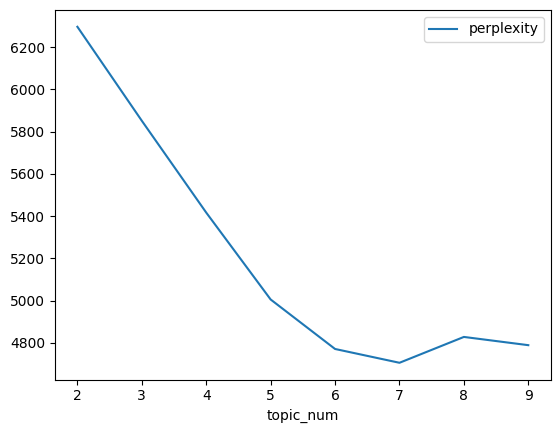

In [37]:
result.plot.line(x='topic_num', y='perplexity')

<AxesSubplot:xlabel='topic_num'>

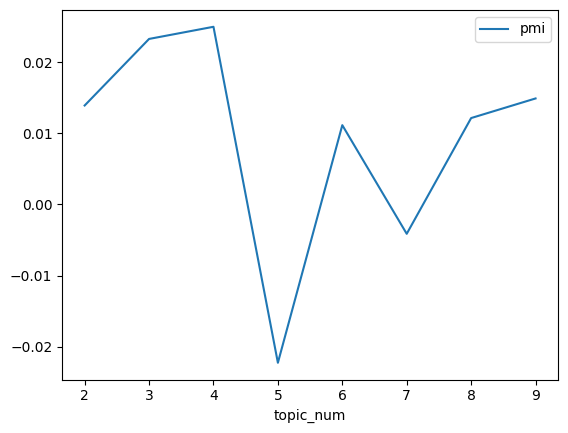

In [38]:
result.plot.line(x='topic_num', y='pmi')

## 視覺化

### 先測試 pmi 最大的主題數4

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

In [40]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.005853  0.200275       1        1  30.540925
0      0.112525  0.009128       2        1  30.054645
1     -0.227135 -0.061254       3        1  22.051318
2      0.108757 -0.148149       4        1  17.353112, topic_info=      Term         Freq        Total Category  logprob  loglift
8278   民進黨  1939.000000  1939.000000  Default  30.0000  30.0000
10811  國民黨  1999.000000  1999.000000  Default  29.0000  29.0000
8682    聯盟  1176.000000  1176.000000  Default  28.0000  28.0000
9886    大谷  1110.000000  1110.000000  Default  27.0000  27.0000
4061    立委  1820.000000  1820.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
4868    民眾   380.685605  1404.221911   Topic4  -5.6822   0.4461
433     希望   364.431623  1159.646615   Topic4  -5.7258   0.5939
2662    社會   314.136793   591.514062   Topic4  -5.8743   1.1185
222     擔任   307.131694   563.575004   Topic4  -5.8969   1.1444
679     強調   308.602802   808.823430   Topic4  -5.8921   0.7879

[313 rows x 6 columns], token_table=       Topic      Freq Term
term                       
5953       1  0.002949   丈夫
5953       2  0.958408   丈夫
5953       3  0.014745   丈夫
5953       4  0.026541   丈夫
16086      3  0.996331   三振
...      ...       ...  ...
5162       1  0.001668  黃子佼
5162       2  0.988902  黃子佼
5162       3  0.008338  黃子佼
8586       2  0.594430   黨團
8586       4  0.404789   黨團

[648 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

從上面結果看到每個主題都可以分的清楚
* 主題一：生活 (多為天氣相關)
* 主題二：天災人禍 (負面相關新聞)
* 主題三：職棒賽事
* 主題四：政治

## 再來測試 perplexity 最低的主題數 7

In [ ]:
model_7 = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

In [42]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_7, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.152462 -0.054645       1        1  21.873185
5      0.080040  0.036452       2        1  18.812303
6     -0.102863  0.177400       3        1  15.097580
0      0.141846  0.114905       4        1  13.677736
4     -0.146757  0.024820       5        1  12.656407
1     -0.071849 -0.215154       6        1  10.514215
3      0.252044 -0.083778       7        1   7.368575, topic_info=      Term         Freq        Total Category  logprob  loglift
9886    大谷  1259.000000  1259.000000  Default  30.0000  30.0000
4380    地震  1681.000000  1681.000000  Default  29.0000  29.0000
4424    花蓮  1568.000000  1568.000000  Default  28.0000  28.0000
8278   民進黨  1206.000000  1206.000000  Default  27.0000  27.0000
10811  國民黨  1207.000000  1207.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
10104  高雄市   170.341630   286.078924   Topic7  -5.6298   2.0895
39      影響   241.882925   887.763537   Topic7  -5.2791   1.3077
1788    萬元   210.578928   888.167678   Topic7  -5.4177   1.1686
894     指出   196.477185  1485.565881   Topic7  -5.4871   0.5849
977     台灣   191.018701  3015.332593   Topic7  -5.5152  -0.1511

[537 rows x 6 columns], token_table=      Topic      Freq Term
term                      
753       1  0.114003   一名
753       2  0.005846   一名
753       3  0.220698   一名
753       4  0.482320   一名
753       5  0.002923   一名
...     ...       ...  ...
4473      1  0.974353  黑嘉嘉
8586      1  0.002328   黨團
8586      2  0.002328   黨團
8586      3  0.090774   黨團
8586      5  0.905414   黨團

[1500 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 7, 1, 5, 2, 4])

* 主題一：國際、兩岸相關新聞
* 主題二：地震
* 主題三：負面社會新聞
* 主題四：戰爭、交通相關新聞
* 主題五：政治
* 主題六：主要為運動賽事
* 主題七：主要和天氣相關


<font color='#ffa'>
從結果可以看出主題 一、五 有些許重疊。
從主題字中可以看出主題一主要是在討論兩岸相關議題以及一些娛樂新聞，而主題五則是政治相關。
</br></br>
圖表中也可以看出主題二和四相當接近，推測是因為戰爭以及地震都是會造成傷亡的負面事件，因此在圖中也較為接近。
</font>

# 3. GuidedLDA

In [43]:
import guidedlda

In [44]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('之外', '也許', '代言人', '佩戴', '依然', '側邊', '儀器', '優異', '全新', '兩地')

In [45]:
word2id = dictionary.token2id


### 給予預先定義的 Seed
<font color='#ffa'>
我們先決定了六個類別，分別是運動、娛樂、汽車、國際、天氣以及政治，並且給予每個類別一些 seed words。
</font>

In [46]:
seed_topic_ch = ['運動', '娛樂', '汽車', '國際', '天氣', '政治']

seed_topic_list = [
    ["聯盟", "大谷", "球員", "比賽", "翔平", "奧運", "球迷"],
    ['粉絲', '電影', '演唱會', '拍攝', '導演', '音樂', '觀眾'],
    ["車主", "車輛", "汽車", "輔助", "搭載", "車款", "性能"],
    ["中國", "美國", "以色列", "伊朗", "攻擊", "國家", "拜登"],
    ["天氣", "雷雨", "醫師", "溫度", "學校", "食物中毒", "調查"],
    ["立委", "總統", "賴清德", "黨團", "兩岸", "行政院", "內閣"]
]

In [47]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [48]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [49]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-05 23:51:43,490 : INFO : n_documents: 4492
2024-05-05 23:51:43,491 : INFO : vocab_size: 16190
2024-05-05 23:51:43,492 : INFO : n_words: 644058
2024-05-05 23:51:43,493 : INFO : n_topics: 6
2024-05-05 23:51:43,493 : INFO : n_iter: 100
2024-05-05 23:51:45,386 : INFO : <0> log likelihood: -7196465
2024-05-05 23:51:45,911 : INFO : <20> log likelihood: -5656211
2024-05-05 23:51:46,424 : INFO : <40> log likelihood: -5598476
2024-05-05 23:51:46,939 : INFO : <60> log likelihood: -5582997
2024-05-05 23:51:47,450 : INFO : <80> log likelihood: -5574810
2024-05-05 23:51:47,956 : INFO : <99> log likelihood: -5571595


In [50]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}：{}".format(seed_topic_ch[i], " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 運動：黃子佼 影片 網友 發現 一名 事件 未成年 萬元 詐騙 發文
Topic 娛樂：台北 粉絲 網友 台灣 活動 真的 覺得 希望 一起 分享
Topic 汽車：地震 花蓮 發生 民眾 警方 目前 新聞 熱門 規模 強震
Topic 國際：台灣 美國 中國 日本 公司 指出 國際 提供 以色列 外電
Topic 天氣：天氣 短暫 地區 陣雨 局部 降雨 機率 多雲 醫師 醫院
Topic 政治：民進黨 國民黨 立委 總統 台灣 台北 立法院 政府 賴清德 馬英九


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.183835 -0.060016       1        1  28.142056
2      0.166536 -0.015324       2        1  18.907323
0     -0.143725 -0.236225       3        1  16.689150
3     -0.035381  0.150542       4        1  13.959219
5     -0.118385  0.202677       5        1  13.634311
4      0.314790 -0.041654       6        1   8.667940, topic_info=     Term         Freq        Total Category  logprob  loglift
4380   地震  1790.000000  1790.000000  Default  30.0000  30.0000
8278  民進黨  1098.000000  1098.000000  Default  29.0000  29.0000
4424   花蓮  1483.000000  1483.000000  Default  28.0000  28.0000
5162  黃子佼  1101.000000  1101.000000  Default  27.0000  27.0000
1278   美國  1080.000000  1080.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
8514   通報   228.439843   452.169613   Topic6  -5.4987   1.7628
894    指出   252.380091  1540.402997   Topic6  -5.3991   0.6367
2657   發生   254.375112  1902.056185   Topic6  -5.3912   0.4337
977    台灣   240.409967  2903.482128   Topic6  -5.4477  -0.0458
4868   民眾   213.477188  1362.793828   Topic6  -5.5665   0.5918

[430 rows x 6 columns], token_table=       Topic      Freq Term
term                       
753        1  0.001350   一名
753        2  0.261833   一名
753        3  0.596548   一名
753        4  0.136315   一名
753        6  0.004049   一名
...      ...       ...  ...
596        6  0.014995   體驗
11038      6  0.997975   高溫
15147      5  1.001283   黃國
5162       3  0.999666  黃子佼
8586       5  0.998898   黨團

[837 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4, 6, 5])

<font color='#ffa'>
根據模型的結果，模型在娛樂、國際、天氣、政治這四個主題都分類的蠻準確的，在運動以及汽車主題相對沒有那麼準確。
</br></br>
模型將原先的運動主題分類成社會負面新聞，推測可能的原因是，最近有發生大谷翔平遭翻譯挪用資金簽賭的負面新聞，因此模型將運動以及負面新聞連結在一起。
</br></br>
模型將原先的汽車主題分類成地震相關新聞，推測可能的原因是，地震發生時有許多與汽車有關的災情，因此地震相關新聞可能時常出現汽車、駕駛等字詞，因此模型將汽車與地震相關新聞結合在一起。
</font>

<font color='#ffa'>
從最後分類的結果中可以看出，相較於 LDA 模型，加入Seed Words 的 GuideLDA 更加準確的將類別分割出來，每個主題也更為明確。
</br>
</br>
GuideLDA 比較不會發生將兩個不太相關的主題和在一起的現象，例如 LDA 中就將兩岸以及娛樂新聞結合在一起。

</font>

# 主題分布的應用

In [72]:
# 取得每條新聞的主題分佈
topics_doc = model_7.get_document_topics(corpus)

In [73]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.15048948, 0.72815967, 0.        , ..., 0.        , 0.11802936,
        0.        ],
       [0.        , 0.        , 0.59029746, ..., 0.        , 0.17423016,
        0.20388664],
       [0.        , 0.45796573, 0.45166761, ..., 0.        , 0.08514803,
        0.        ],
       ...,
       [0.02009206, 0.19711445, 0.        , ..., 0.77711487, 0.        ,
        0.        ],
       [0.        , 0.02408972, 0.        , ..., 0.9710049 , 0.        ,
        0.        ],
       [0.        , 0.1652898 , 0.1487682 , ..., 0.37610957, 0.        ,
        0.        ]])

In [74]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [75]:
udn['topic_label'].value_counts()

topic_label
3    1165
6     842
1     681
7     602
5     465
2     460
4     277
Name: count, dtype: int64

In [76]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,記者劉旻君台北報導若是經常出遊的派也許對日本鐘錶品牌的系列不陌生近日該系列又有新作登場端出首...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 18:41:00,"[劉旻君, 台北, 出遊, 也許, 日本, 鐘錶, 品牌, 系列, 陌生, 近日, 系列, ...",2
1,王怡人綜合報導歲最美士官長劉香慈和永信藥品總經理鍾威凱育有子兩人婚姻剛跨越七年之癢她開心懷上...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 07:52:00,"[王怡, 最美, 士官長, 劉香, 慈和, 永信, 藥品, 總經理, 威凱育, 有子, 兩人...",3
2,記者林秭渝台北報導曾奪下亞洲東亞世界運動會的健美比賽拿過銀牌金牌和銅牌的許家豪與從歌手轉戰健...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 18:10:00,"[秭渝, 台北, 奪下, 亞洲, 東亞, 世界, 運動會, 健美, 比賽, 拿過, 銀牌, ...",2
3,吳惠菁綜合報導愚人節搞笑日本電視台生活資訊節目突然插播北韓領導人金正恩閱兵的影片引起網友恐慌...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 11:58:00,"[吳惠菁, 愚人節, 搞笑, 日本, 電視, 生活, 資訊, 節目, 突然, 插播, 北韓,...",3
4,記者陳薇安綜合報導打造出經典劇如果歲還是處男似乎就能成為魔法師的日本東京電視台又有新作推出改...,https://tw.nextapple.com/entertainment/2024040...,娛樂時尚,2024-04-01 21:46:00,"[打造出, 經典, 處男, 似乎, 成為, 魔法師, 日本, 東京, 電視, 新作, 推出,...",3


In [136]:
udn['artDate'] = pd.to_datetime(udn['artDate'])
udn['artDate'].dt.date

0       2024-04-01
1       2024-04-01
2       2024-04-01
3       2024-04-01
4       2024-04-01
           ...    
4487    2024-04-22
4488    2024-04-22
4489    2024-04-22
4490    2024-04-22
4491    2024-04-22
Name: artDate, Length: 4492, dtype: object

In [78]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-04-01  3              0.311224
            2              0.168367
            1              0.132653
            5              0.107143
            7              0.096939
                             ...   
2024-04-22  6              0.150754
            7              0.140704
            2              0.115578
            4              0.075377
            5              0.075377
Name: proportion, Length: 154, dtype: float64

In [79]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6,7
artDate,,,,,,,
2024-04-01,0.132653,0.168367,0.311224,0.091837,0.107143,0.091837,0.096939
2024-04-02,0.153846,0.183761,0.299145,0.038462,0.085470,0.128205,0.111111
2024-04-03,0.132492,0.028391,0.157729,0.028391,0.031546,0.580442,0.041009
2024-04-04,0.116505,0.058252,0.266990,0.043689,0.048544,0.402913,0.063107
2024-04-05,0.119048,0.101190,0.220238,0.059524,0.017857,0.375000,0.107143


* 主題一：政治
* 主題二：戰爭、交通相關新聞
* 主題三：兩岸相關新聞
* 主題四：主要和天氣相關
* 主題五：主要為運動賽事
* 主題六：地震
* 主題七：負面社會新聞

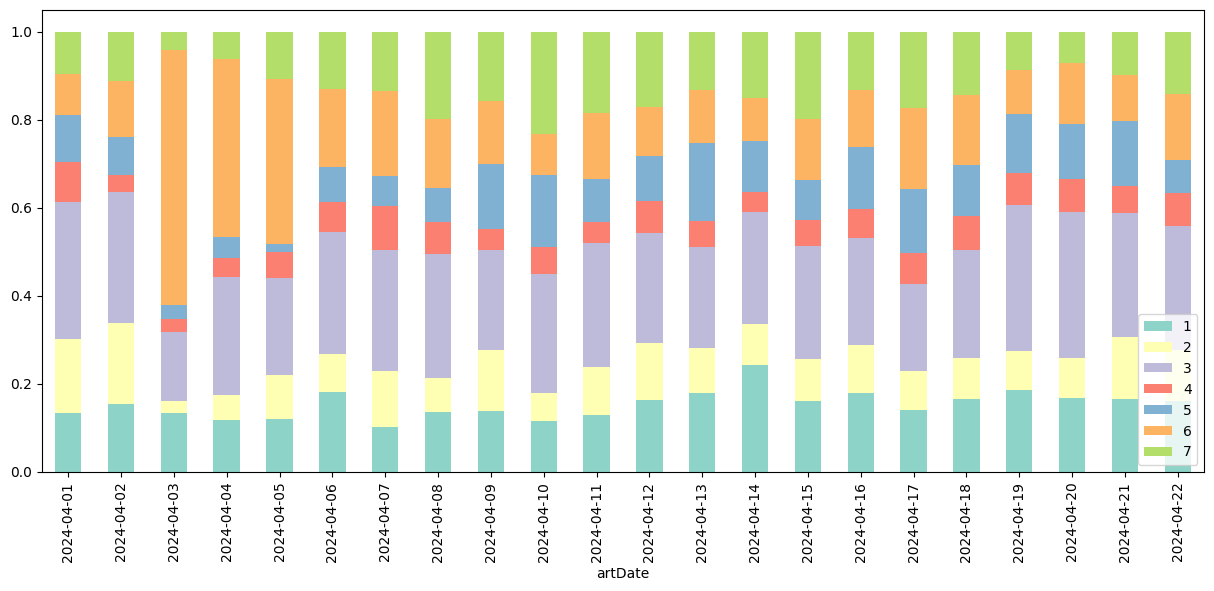

In [80]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

<font color='#ffa'>
可以看到 4/3 ~ 4/5 主題六（地震）的討論比例很高，因為4/3台灣發生了大地震，因此該段時間討論的比例特別高。
</br></br>
圖表中也可以發現主題三在大部分的時候都是占比最高的主題，主題三中主要是與兩岸相關的新聞，可見台灣媒體對於兩岸議題非常關注。
</font>